# California House Prices Prediction

This project focuses on predicting median house values in California using machine learning regression techniques. The dataset used for this project is sourced from the US Census Bureau and contains various metrics such as population, median income, and median housing price for each block group in California.

## About the Dataset

The dataset provides detailed information about 20,640 districts or block groups in California. Each block group represents the smallest geographical unit for which the US Census Bureau publishes sample data, typically comprising a population of 600 to 3,000 people.

The goal of this project is to develop a model that can accurately predict the median housing price in any district based on the other provided metrics. Such models can contribute to understanding housing trends and aid in decision-making processes related to real estate investments and policy planning.

**Dataset Source:** [California Census Data](https://www.kaggle.com/datasets/shibumohapatra/house-price)

**Domain:** Finance and Housing

### Preparing the environment

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold,cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import shap
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Set a seed for reproductibility
np.random.seed(42)
# Read in the dataset
housing = pd.read_csv('/kaggle/input/house-price/1553768847-housing.csv')

# Set palette
sns.set_palette("rainbow")

## Exploratory Data Analysis

Before delving into building predictive models, it is crucial for thorough Exploratory Data Analysis to be performed in order to gain insights into the dataset and understand the relationships between variables. In this section, various aspects of the dataset, including its structure, summary statistics, and distributions of key variables, will be explored.

### Basic information and data cleaning

In [2]:
#Look at the dataset summary statistics
print(housing.shape)
print(housing.head())
print(housing.info())
print(housing.describe())
print(housing.dtypes)
print(f"\n Median values: \n {housing.select_dtypes(include='number').median()}")
print(f"\n Mean values: \n {housing.select_dtypes(include='number').mean()}")

(20640, 10)
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                  41          880           129.0   
1    -122.22     37.86                  21         7099          1106.0   
2    -122.24     37.85                  52         1467           190.0   
3    -122.25     37.85                  52         1274           235.0   
4    -122.25     37.85                  52         1627           280.0   

   population  households  median_income ocean_proximity  median_house_value  
0         322         126         8.3252        NEAR BAY              452600  
1        2401        1138         8.3014        NEAR BAY              358500  
2         496         177         7.2574        NEAR BAY              352100  
3         558         219         5.6431        NEAR BAY              341300  
4         565         259         3.8462        NEAR BAY              342200  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries

In [3]:
# Check for duplicates
print(f"Number of duplicated rows: {housing.duplicated().sum()}")

# Check for missing values
print(f"Number of missing values in each column: \n {housing.isnull().sum()}")

# Calculate the percentage of missing values in 'total_bedrooms'
print(f"Percentage of missing values in 'total_bedrooms' column: \n {housing['total_bedrooms'].isnull().sum() / len(housing) * 100:.6f}%")


Number of duplicated rows: 0
Number of missing values in each column: 
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64
Percentage of missing values in 'total_bedrooms' column: 
 1.002907%


Since the percentage of missing values in 'total_bedrooms' column is relatively low (around 1%), the rows with missing values were dropped.

In [4]:
#Drop missing values 
housing.dropna(subset=['total_bedrooms'], inplace=True)
#Check for missing values again
print(f"Number of missing values in 'total_bedrooms': \n {housing['total_bedrooms'].isnull().sum()}")

Number of missing values in 'total_bedrooms': 
 0


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

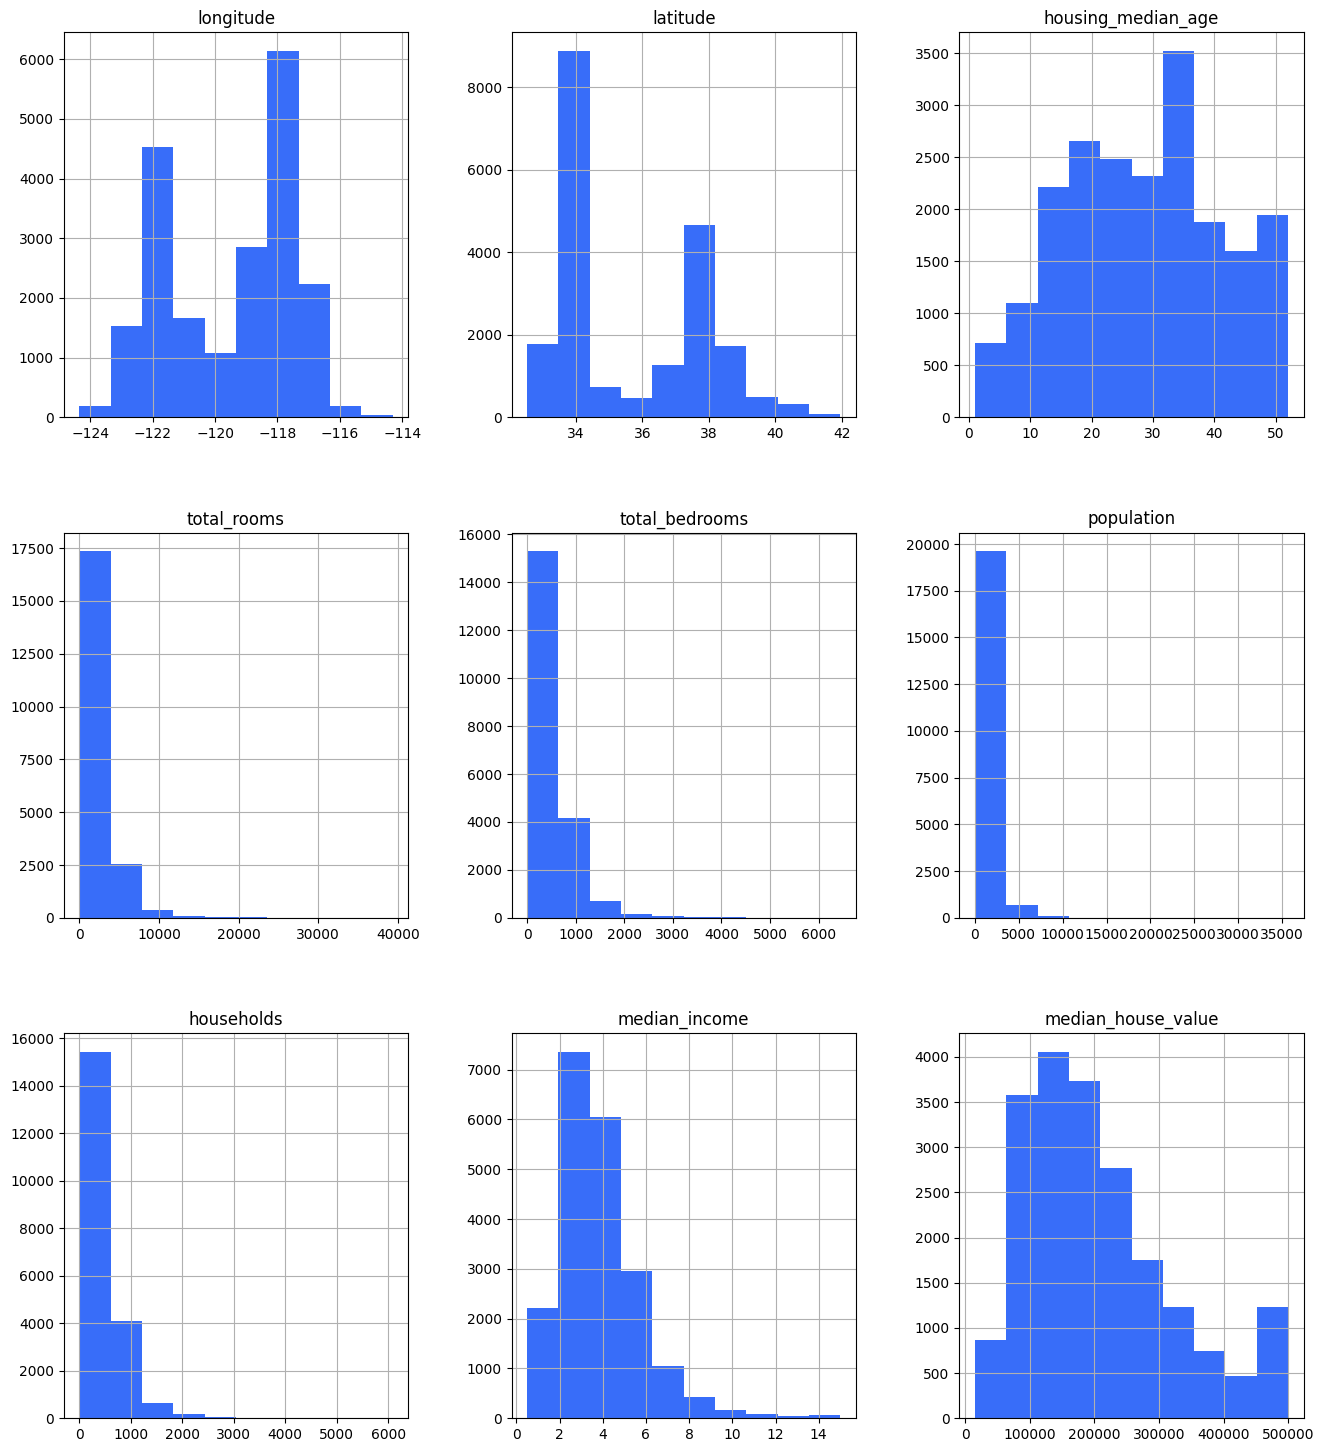

In [5]:
#Check the distribution of numerical variables
housing.hist(figsize = (16,18))

### Check the only categorical feature: 'ocean_proximity'

When analyzing the categorical feature 'ocean_proximity', it was observed that there are five distinct categories. However, the training set 'ISLAND' category had only four rows of data, which was deemed insufficient for meaningful analysis. As a result, these rows were dropped from the dataset.


['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']
ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64
ocean_proximity
<1H OCEAN     0.442128
INLAND        0.317917
NEAR OCEAN    0.128615
NEAR BAY      0.111095
ISLAND        0.000245
Name: proportion, dtype: float64


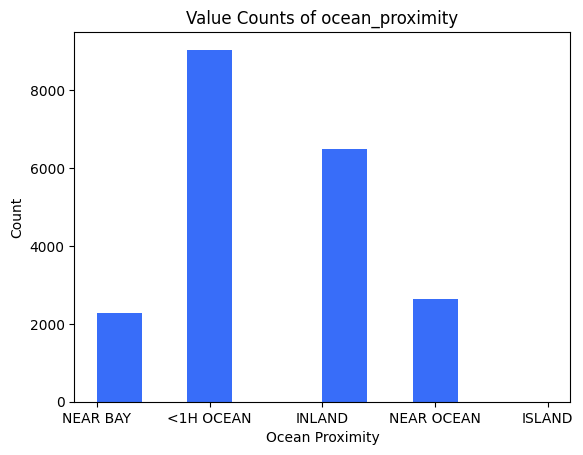

In [6]:
print(housing['ocean_proximity'].unique())
print(housing['ocean_proximity'].value_counts())
print(housing['ocean_proximity'].value_counts(normalize=True))
plt.hist(housing['ocean_proximity'])
plt.title('Value Counts of ocean_proximity')
plt.xlabel('Ocean Proximity')
plt.ylabel('Count')
plt.show()
housing.drop(housing[housing['ocean_proximity'] == 'ISLAND'].index, inplace=True)

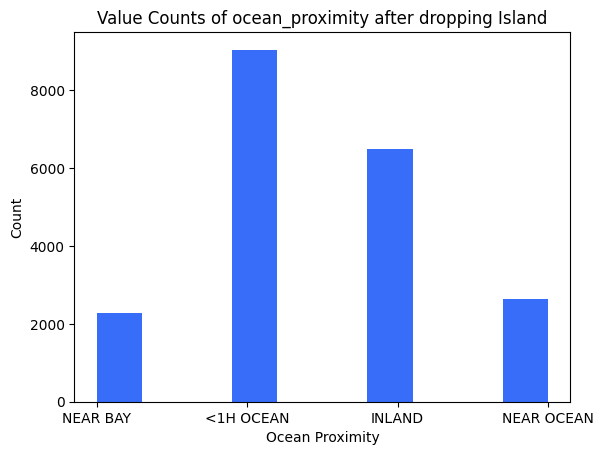

In [7]:
# Display updated 'ocean_proximity' column
plt.hist(housing['ocean_proximity'])
plt.title('Value Counts of ocean_proximity after dropping Island')
plt.xlabel('Ocean Proximity')
plt.ylabel('Count')
plt.show()

### Splitting into Train and Test Sets

At this stage, the dataset was divided into separate train and test sets. This division ensures that more detailed analysis is conducted solely on the training set, preventing any data leakage from the test set.

In [8]:
X = housing.drop('median_house_value', axis=1)
y = housing['median_house_value']
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
df = pd.concat([X_train, y_train], axis=1)

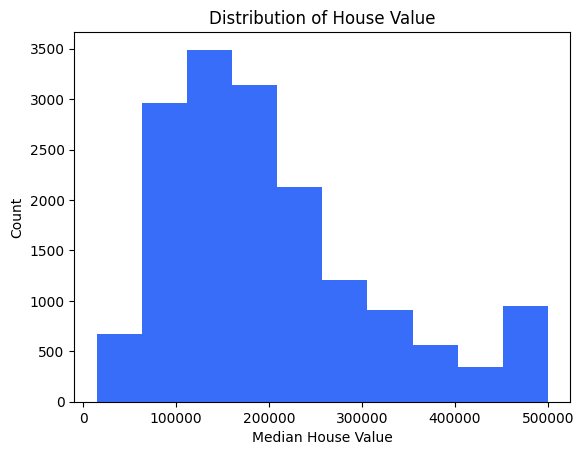

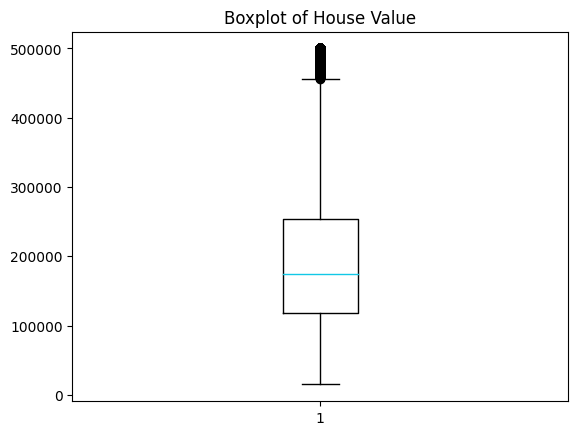

Interquartile Range: 135300.0
Number of lower outliers: 0
Number of upper outliers: 921
Total number of outliers: 921
0.056357850936237915


In [9]:
plt.hist(df['median_house_value'])
plt.title('Distribution of House Value')
plt.xlabel('Median House Value')
plt.ylabel('Count')
plt.show()

plt.boxplot(df['median_house_value'])
plt.title('Boxplot of House Value')
plt.show()

# Calculate threshold
q1 = df['median_house_value'].quantile(0.25)
q3 = df['median_house_value'].quantile(0.75)

# Calculate IQR
iqr = q3 - q1
# Print the interquartile range (IQR)
print(f"Interquartile Range: {iqr}")

# Identify outliers
lower_outliers = df['median_house_value'][df['median_house_value'] < q1 - 1.5 * iqr]
upper_outliers = df['median_house_value'][df['median_house_value'] > q3 + 1.5 * iqr]

# Calculate the number of outliers and print the results
num_lower_outliers = len(lower_outliers)
num_upper_outliers = len(upper_outliers)
num_total_outliers = num_lower_outliers + num_upper_outliers
print(f"Number of lower outliers: {num_lower_outliers}")
print(f"Number of upper outliers: {num_upper_outliers}")
print(f"Total number of outliers: {num_total_outliers}")
print(num_total_outliers/len(df['median_house_value']))

In [10]:
# Drop outliers from the test set
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df[(df['median_house_value'] > lower_bound) & (df['median_house_value'] < upper_bound)]

In [11]:
# Drop outliers from the entire set
indices_to_keep = np.where((y_shuffled > lower_bound) & (y_shuffled < upper_bound))[0]

X_shuffled = X_shuffled.iloc[indices_to_keep]
y_shuffled = y_shuffled.iloc[indices_to_keep]

print("Shape of X_shuffled after dropping rows:", X_shuffled.shape)
print("Shape of y_shuffled after dropping rows:", y_shuffled.shape)


Shape of X_shuffled after dropping rows: (19228, 9)
Shape of y_shuffled after dropping rows: (19228,)


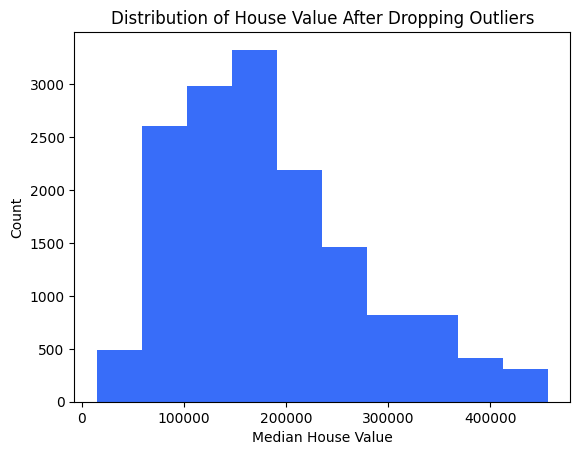

In [12]:
# Check the distribution again

plt.hist(df['median_house_value'])
plt.title('Distribution of House Value After Dropping Outliers')
plt.xlabel('Median House Value')
plt.ylabel('Count')
plt.show()

Outliers were identified and removed from the dataset using the interquartile range method. First, outliers were dropped from the training set based on the and then from the entire dataset. This approach ensures that extreme values, which may skew the analysis or modeling process, are excluded from the dataset.

### Feature engineering

Text(0.5, 1.0, 'Geographical Distribution of House Prices')

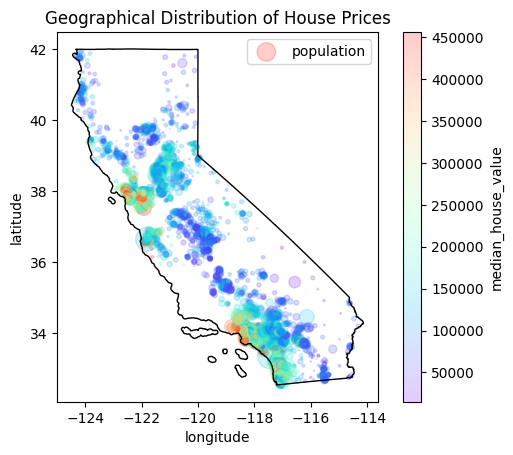

In [13]:
# Load the California map
path_to_shp = "/kaggle/input/us-maps/tl_2023_us_state.shp"
california = gpd.read_file(path_to_shp)
california = california[california.STUSPS == "CA"]

# Create a scatter plot of geographical distribution of house prices
df.plot(kind='scatter', x='longitude', y='latitude', s=df['population']/100, label='population', c='median_house_value', alpha=0.2, colorbar=True, sharex=False, cmap=plt.get_cmap('rainbow'))
california.plot(ax=plt.gca(), edgecolor='black', facecolor='none')
plt.title('Geographical Distribution of House Prices')

The geospatial plot suggests that median house value is the highest in the areas near the bay, which could suggest that the ocean_proximity feature will be an important one in the modelling process.

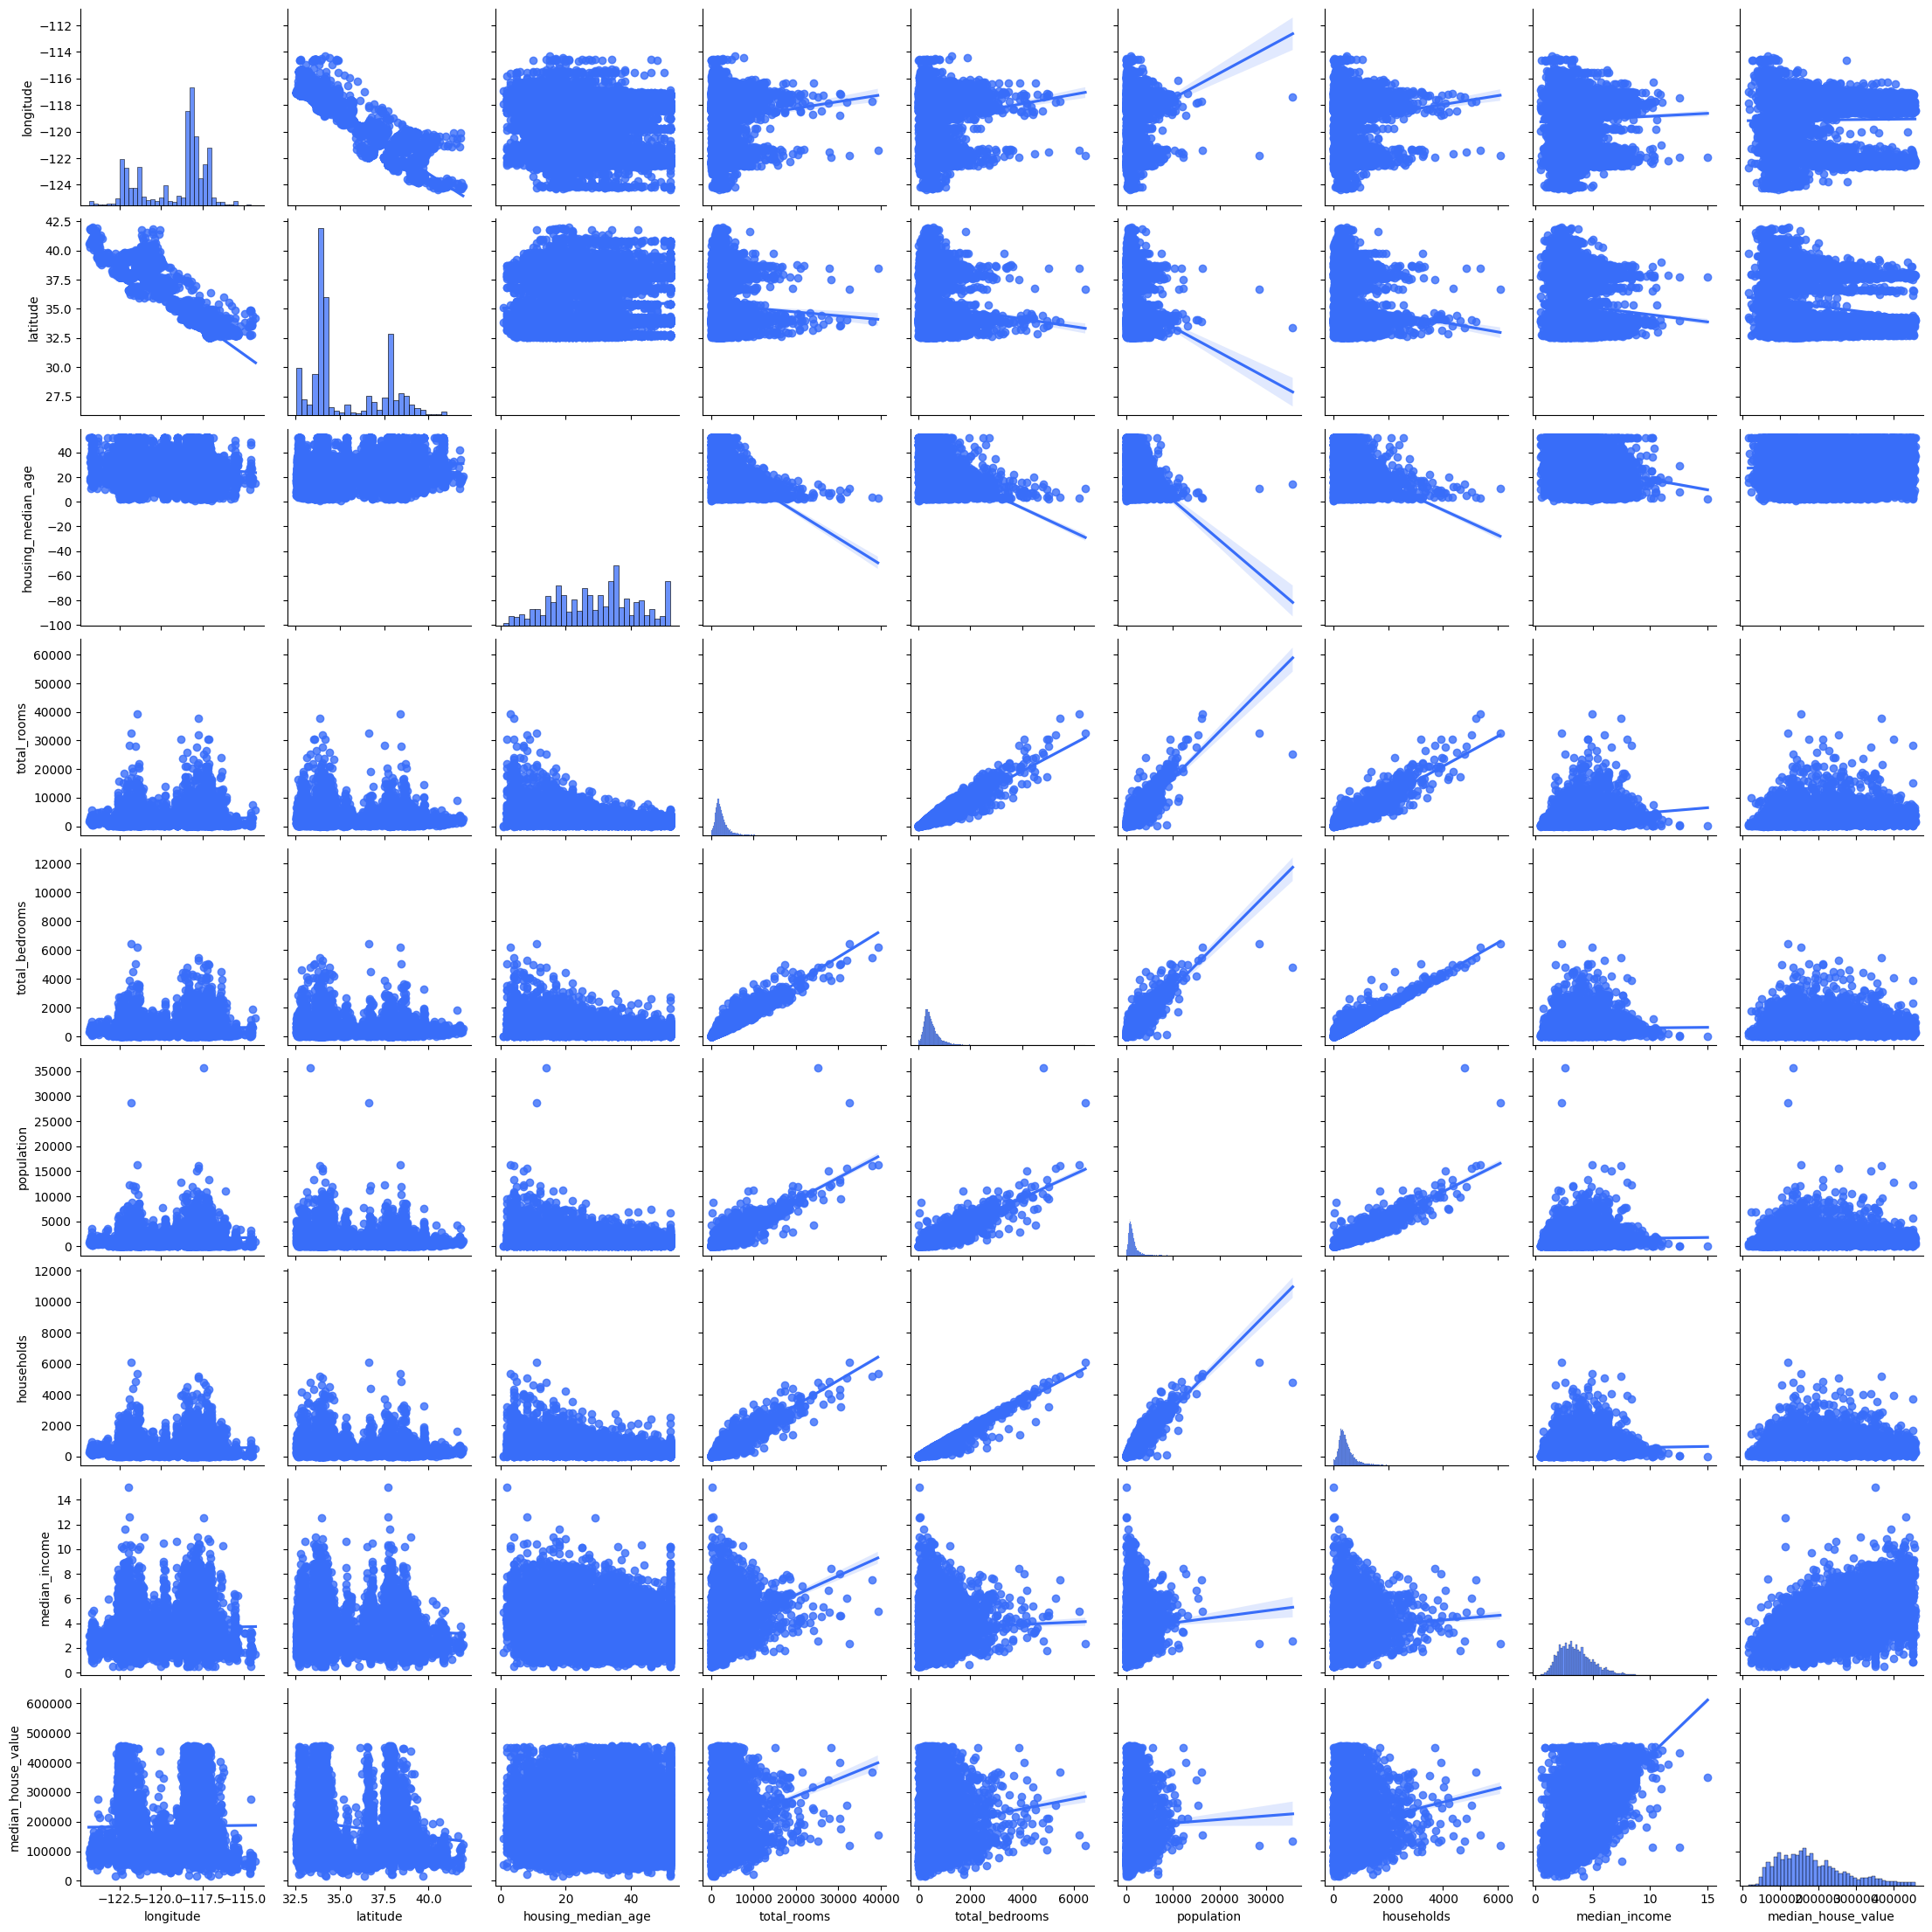

In [14]:
sns.pairplot(df,kind='reg')

Text(0.5, 1.0, 'Correlation Matrix of The Test Set')

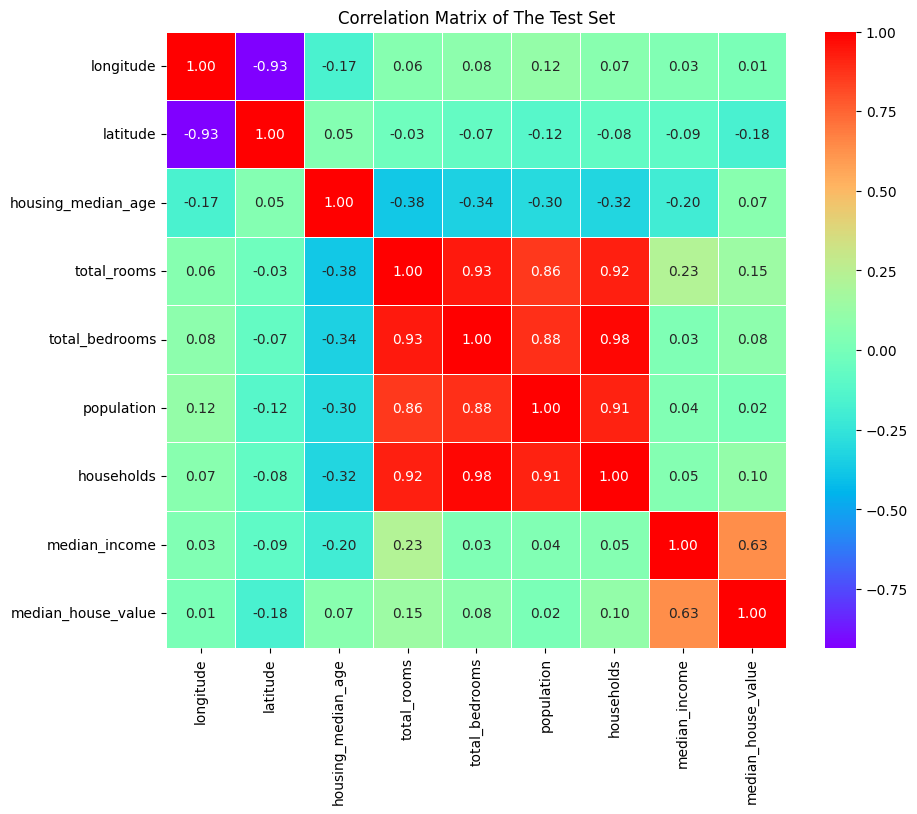

In [15]:
#Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, fmt=".2f", linewidths=0.5, cmap = "rainbow")
plt.title('Correlation Matrix of The Test Set')

As expected, housholds, population, total rooms (without bedrooms) and total bedrooms are highly correlated.

Based on the above plots and correlation matrix, it seems that median income has moderately strong positive correlation with median house value, so let's zoom in on the scatterplot seen in pairplot:

Text(0, 0.5, 'Median Income')

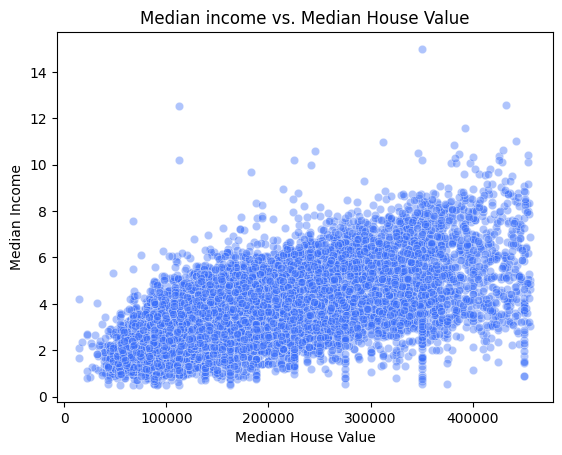

In [16]:
# Create scatter plot with a line
ax = sns.scatterplot(data=df, x='median_house_value', y='median_income', alpha=0.4)
plt.title('Median income vs. Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Median Income')

### Feature engineering

Looking at the dataset, there is potential to create new features out of the existing ones.

In [17]:
# Create new features

# Population density (population per households)
df['pop_density'] = df['population']/df['households']
# Bedroom density (bedrooms per household)
df['bed_density'] = df['total_bedrooms']/df['households']
# Room density (rooms per household)
df['room_density'] = df['total_rooms']/df['households']
# Rooms per bedroom
df['rooms_per_bedroom'] = df['total_rooms']/df['total_bedrooms']
# Rooms per person
df['rooms_per_person'] = df['total_rooms']/df['population']
# Bedrooms per person
df['rooms_per_person'] = df['total_bedrooms']/df['population']
# Bedrooms per Total Rooms
df['bedrooms_per_total_rooms'] = df['total_bedrooms'] / (df['total_rooms'] + df['total_bedrooms'])
# Rooms per Total Rooms
df['rooms_per_total_rooms'] = df['total_rooms'] / (df['total_rooms'] + df['total_bedrooms'])

Text(0.5, 1.0, 'Correlation Matrix of New Features')

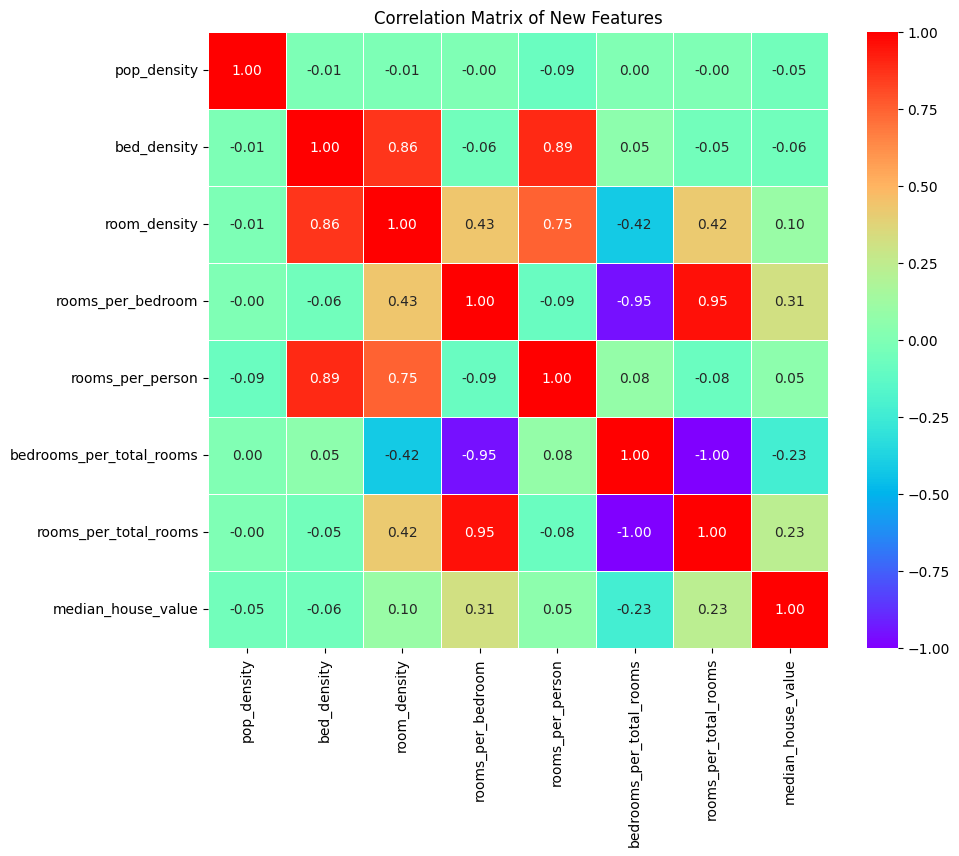

In [18]:
#Plot correlation matrix
new_cols = ['pop_density', 'bed_density', 'room_density', 'rooms_per_bedroom', 'rooms_per_person', 'bedrooms_per_total_rooms', 'rooms_per_total_rooms']
new_matrix = new_cols + ['median_house_value']
corr = df[new_matrix].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=0.5, cmap = "rainbow")
plt.title('Correlation Matrix of New Features')


The decision has been made to keep `rooms_per_bedroom` instead of `rooms_per_total_rooms` and `bedrooms_per_total_rooms`. This choice is based on the high correlation between `rooms_per_total_rooms`/ `bedrooms_per_total_rooms` and `rooms_per_bedroom` (correlation coefficient of 0.95). The aim is to avoid multicollinearity in the model, and since `rooms_per_bedroom` exhibits the highest correlation with the target variable among the new features (correlation coefficient of 0.31), it is prioritized for retention.

## Perform Simple Feature Selection with The New Features

To inspect the new vs. old features further, feature selectoin was performed. To do that, Random Forest with Recursive Feature Elimination was employed: RFE selected a subset of 10 features that contributed the most to the model's predictive performance.

10 features chosen were:
- longitude
- latitude
- housing_median_age
- households
- median_income
- pop_density
- room_density
- rooms_per_bedroom
- rooms_per_person
- ocean_proximity_encoded

In [19]:
# Encode the 'ocean_proximity' column
custom_order = {
    'NEAR BAY': 1,
    '<1H OCEAN': 2,
    'INLAND': 3,
    'NEAR OCEAN': 4,
}

df['ocean_proximity_encoded'] = df['ocean_proximity'].map(custom_order)
print(df['ocean_proximity_encoded'].head())
df = df.drop(columns='ocean_proximity', axis=1)

0    1
1    1
2    1
3    1
4    1
Name: ocean_proximity_encoded, dtype: int64


In [20]:
# Drop chosen features
X = df.drop(columns=['median_house_value', 'rooms_per_total_rooms','bedrooms_per_total_rooms'], axis=1)
y = df['median_house_value']

# Instantiate the RFE estimator with RF
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator, n_features_to_select=10)  

# Fit RFE to data and get features
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]

# Train RF model with selected features and retrieve feature importance
X_selected = X[selected_features]
model = estimator.fit(X_selected, y)
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importance})
print("Feature Importance:")
print(feature_importance_df)

Feature Importance:
                   Feature  Importance
0                longitude    0.092720
1                 latitude    0.075163
2       housing_median_age    0.046744
3               households    0.033235
4            median_income    0.404880
5              pop_density    0.105774
6             room_density    0.026382
7        rooms_per_bedroom    0.034338
8         rooms_per_person    0.041833
9  ocean_proximity_encoded    0.138932


In [21]:
# Map ocean encoding
X_shuffled['ocean_proximity_encoded'] = X_shuffled['ocean_proximity'].map(custom_order)
X_shuffled = X_shuffled.drop(columns='ocean_proximity', axis=1)

# Add new selected features to X_shuffled

# Calculate population density (population per households)
X_shuffled['pop_density'] = X_shuffled['population'] / X_shuffled['households']

# Calculate room density (rooms per household)
X_shuffled['room_density'] = X_shuffled['total_rooms'] / X_shuffled['households']

# Calculate rooms per bedroom
X_shuffled['rooms_per_bedroom'] = X_shuffled['total_rooms'] / X_shuffled['total_bedrooms']

# Calculate rooms per person
X_shuffled['rooms_per_person'] = X_shuffled['total_rooms'] / X_shuffled['population']

# Keep only selected features
X_shuffled_sel = X_shuffled[selected_features]
print(X_shuffled.head())

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
11998    -117.56     33.94                  29          266            42.0   
6807     -118.10     34.09                  44         2352           484.0   
13029    -121.19     38.67                  16         1754           284.0   
20099    -120.24     37.96                  34         1747           395.0   
20480    -118.70     34.28                  25         2377           491.0   

       population  households  median_income  ocean_proximity_encoded  \
11998         136          40         1.6250                        3   
6807         1517         463         4.2833                        2   
13029         773         277         4.8170                        3   
20099         935         362         1.6250                        3   
20480        1200         439         4.7083                        2   

       pop_density  room_density  rooms_per_bedroom  rooms_per_person  
11998     3.40

In [22]:
# Split the set again after changes done during EDA
X_train, X_test, y_train, y_test = train_test_split(X_shuffled_sel, y_shuffled, test_size=0.2, random_state=42, shuffle=False)

## Model selection 

This stage aimed to select the optimal regression model for further and refinement. The evaluation metric used for comparing models was the coefficient of determination (R^2 score), a metric that measures the proportion of the variance in the target variable that is predictable from the features.

Five regression algorithms were considered for evaluation:

- Decision Tree
- Random Forest
- Lasso
- SVM
- Ridge

Each model was instantiated with default parameters and subjected to 5-fold cross-validation. The resulting R^2 scores were aggregated and visualized using boxplots, to compare the performance and potential for each model.

While Decision Trees, Ridge and Lasso Regression performed similarly well, Random Forest had superior performance compared to other models and it was selected for further tuning in the next steps.

Moreover, Lasso regression was chosen out of simpler algorithms to compare performance of RF.

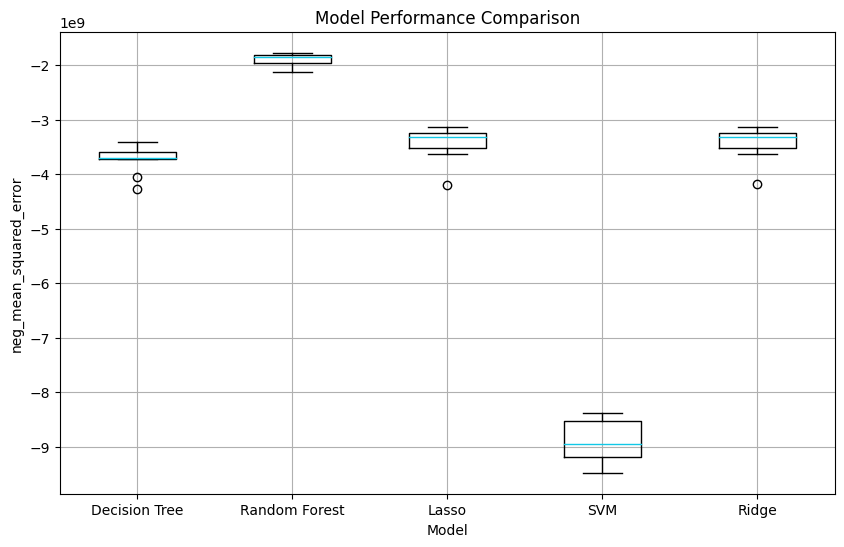

{'Decision Tree': array([-3.50410768e+09, -3.72520480e+09, -4.05456908e+09, -3.40949948e+09,
        -3.57622432e+09, -4.27342906e+09, -3.60822722e+09, -3.71959096e+09,
        -3.66789061e+09, -3.72618790e+09]),
 'Random Forest': array([-1.82034685e+09, -1.83928404e+09, -2.08601315e+09, -1.80264852e+09,
        -1.84928404e+09, -1.98681797e+09, -1.77610357e+09, -1.84308165e+09,
        -1.76929225e+09, -2.12975554e+09]),
 'Lasso': array([-3.29003663e+09, -3.24707692e+09, -3.63607610e+09, -3.33163334e+09,
        -3.52751678e+09, -4.18872072e+09, -3.24324865e+09, -3.22719579e+09,
        -3.14036362e+09, -3.48216856e+09]),
 'SVM': array([-9.47561252e+09, -8.41854677e+09, -8.97223900e+09, -8.91999579e+09,
        -8.85358590e+09, -8.38506595e+09, -9.47999049e+09, -9.18832331e+09,
        -8.39806530e+09, -9.17139744e+09]),
 'Ridge': array([-3.29004658e+09, -3.24704784e+09, -3.63611869e+09, -3.33164726e+09,
        -3.52748883e+09, -4.18818748e+09, -3.24328744e+09, -3.22722736e+09,
     

In [23]:
# Define models dictionary and scoring metric
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Lasso': Lasso(random_state=42),
    'SVM': SVR(),
    'Ridge': Ridge()
}

scoring_metric = 'neg_mean_squared_error'

# Define function for model selection
def model_selection(models, scoring_metric, X_train=X_train, y_train=y_train):
    '''
    This function performs model selection by evaluating the performance of different models using cross-validation.
    
    Parameters:
    - models (dict): A dictionary containing model names as keys and corresponding model instances as values.
    - scoring_metric (str): The evaluation metric to use for comparing models.
    - X_train (array-like): The feature matrix of the training data.
    - y_train (array-like): The target vector of the training data.
    
    Returns:
    - results (dict): A dictionary containing model names as keys and the corresponding cross-validation results as values.
    '''
    results = {}
    
    for model_name, model in models.items():
        kf = KFold(n_splits=10, random_state=12, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring_metric)
        results[model_name] = cv_results

    plt.figure(figsize=(10, 6))
    plt.boxplot(results.values(), labels=results.keys())
    plt.title('Model Performance Comparison')
    plt.xlabel('Model')
    plt.ylabel(scoring_metric)
    plt.grid(True)
    plt.show()
    
    return results

model_selection(models, scoring_metric)

## Hyperparameter Tuning for Lasso Regression Random Forest Regressor

In this step, the chosen models (RF Regressor and Lasso) were further tuned using randomized search and cross-validation. Numerical features were transformed with Robust Scaler in order to ensure that they are on the same scale. 

### Lasso Regression

In [24]:
from sklearn.preprocessing import PolynomialFeatures, RobustScaler

# Define preprocessor with Robust Scaler and Polynomial features
preprocessor = ColumnTransformer(
    transformers=[
        ('polynomial', PolynomialFeatures(degree=2), [0,1, 2, 3, 4, 5, 6, 7, 8]),
        ('scaler', RobustScaler(), slice(0, None)),
    ],
    remainder='passthrough'
)

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())  
])

param_grid = {
    'regressor__alpha': [5], 
    'regressor__tol': [0.001],
    'regressor__max_iter': [10000]
}

# Fit the Lasso model on training data
lasso_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=10, cv=10, random_state=42, n_jobs=-1, verbose=-1)
lasso_search.fit(X_train, y_train)
print("Best hyperparameters found for Lasso model:")
print(lasso_search.best_params_)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e+13, tolerance: 1.190e+11
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.994e+13, tolerance: 1.203e+11
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e+13, tolerance: 1.194e

Best hyperparameters found for Lasso model:
{'regressor__tol': 0.001, 'regressor__max_iter': 10000, 'regressor__alpha': 5}


In [25]:
# Calculate evaluation metrics on the training set for Lasso
y_train_pred = lasso_search.best_estimator_.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
print("Train Set Evaluation for Lasso:")
print(f"Mean Absolute Error: {mae_train}")
print(f"Mean Squared Error: {mse_train}")
print(f"Root Mean Squared Error: {rmse_train}")
print(f"R^2 Score: {r2_train}")

Train Set Evaluation for Lasso:
Mean Absolute Error: 39297.27354037878
Mean Squared Error: 2847963188.602101
Root Mean Squared Error: 53366.31136402534
R^2 Score: 0.6702884924993605


### Random Forest

In [26]:
# Define preprocessor for Random Forest pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), [0, 1, 2, 3, 4, 5, 6, 7, 8]),
    ],
    remainder='passthrough'
)

# Define the pipeline and parameter grid
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())  
])

param_grid = {
    'regressor__n_estimators': [400], 
    'regressor__bootstrap': [True],
    'regressor__min_impurity_decrease': [0.1], 
    'regressor__max_features': ['sqrt'],
     'regressor__max_depth': [20],  
}

# Fit the RF model on the training data
rf_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=10, cv=5, random_state=42, n_jobs=-1, verbose=2)
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaler',
                                                                               RobustScaler(),
                                                                               [0,
                                                                                1,
                                                                                2,
                                                                                3,
                                                                                4,
                                                                                5,
                                                                                6,
                                                                                7,
                                                                                8])])),
                                             ('regressor',
                                              RandomForestRegressor())]),
                   n_jobs=-1,
                   param_distributions={'regressor__bootstrap': [True],
                                        'regressor__max_depth': [20],
                                        'regressor__max_features': ['sqrt'],
                                        'regressor__min_impurity_decrease': [0.1],
                                        'regressor__n_estimators': [400]},
                   random_state=42, verbose=2)

In [27]:
# Calculate evaluation metrics on the training set
y_train_pred = rf_search.best_estimator_.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
print("Train Set Evaluation for Random Forest:")
print(f"Mean Absolute Error: {mae_train}")
print(f"Mean Squared Error: {mse_train}")
print(f"Root Mean Squared Error: {rmse_train}")
print(f"R^2 Score: {r2_train}")

Train Set Evaluation for Random Forest:
Mean Absolute Error: 11445.907957146013
Mean Squared Error: 269095664.145233
Root Mean Squared Error: 16404.135580555074
R^2 Score: 0.9688465295330029


In [28]:
print("Best hyperparameters found for RF model:")
print(rf_search.best_params_)

Best hyperparameters found for RF model:
{'regressor__n_estimators': 400, 'regressor__min_impurity_decrease': 0.1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 20, 'regressor__bootstrap': True}


## Evaluating Model Performance on The Test Set

After training, the best model of each kind wereevaluated on the test set. The test set was transformed using the transformer fit on the test set.

In [29]:
# Evaluate Lasso model on the test data
y_test_pred = lasso_search.best_estimator_.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)
print("Test Set Evaluation Lasso:")
print(f"Mean Absolute Error: {mae_test}")
print(f"Mean Squared Error: {mse_test}")
print(f"Root Mean Squared Error: {rmse_test}")
print(f"R^2 Score: {r2_test}")

Test Set Evaluation Lasso:
Mean Absolute Error: 39089.15421252761
Mean Squared Error: 2787514216.244744
Root Mean Squared Error: 52796.91483642528
R^2 Score: 0.6715766996154787


In [30]:
# Evaluate RF model on the test data
y_test_pred = rf_search.best_estimator_.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)
print("Test Set Evaluation for Random Forest:")
print(f"Mean Absolute Error: {mae_test}")
print(f"Mean Squared Error: {mse_test}")
print(f"Root Mean Squared Error: {rmse_test}")
print(f"R^2 Score: {r2_test}")

Test Set Evaluation for Random Forest:
Mean Absolute Error: 28207.77058498122
Mean Squared Error: 1673012518.215374
Root Mean Squared Error: 40902.475697876456
R^2 Score: 0.8028866401416517


## Summary

The Lasso model exhibits weaker predictive power compared to the Random Forest model. However, it demonstrates stability across both training and testing sets. On the other hand, the Random Forest model shows signs of overfitting, indicated by the significant difference in performance between training and testing sets. Despite this, it shows overall stronger predictive power.

In conclusion, while the Random Forest model may be prone to overfitting, it offers greater predictive performance. The Lasso model, while less powerful, maintains stability across datasets.